# Posverdad — Entities Pack A (sin vistas)
Dashboards incluidos:
1) **Top Entities** (rango configurable)
3) **Sentiment por entidad** (neg/neu/pos, avg_polarity)
4) **Subjectivity por entidad** (media, p50/p75/p90, % alta ≥ 0.36)
6) **Co-ocurrencias** (pares de entidades más frecuentes)
8) **Spikes/alertas** (picos vs. promedio móvil 7 días)

**Cómo usar**
1. Define los **parámetros** en la siguiente celda (rangos de fechas, tipos de entidad, filtros por medio, límites).
2. Ejecuta todas las celdas (Kernel → Restart & Run All).
3. Ajusta filtros y re-ejecuta las celdas si necesitas.

> El notebook consulta directamente `articles`, `entities`, `articles_entities`, `sources` (sin vistas).


In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import psycopg2
from psycopg2.extras import RealDictCursor
import matplotlib.pyplot as plt
from itertools import combinations

pd.set_option('display.max_rows', 20)

# Credenciales desde variables de entorno
PG = {
    "host": os.getenv("POSTGRES_HOST", "localhost"),
    "port": int(os.getenv("POSTGRES_PORT", "5432")),
    "dbname": os.getenv("POSTGRES_DB", "posverdad"),
    "user": os.getenv("POSTGRES_USER", "posverdad"),
    "password": os.getenv("POSTGRES_PASSWORD", "posverdad"),
}
PG

{'host': 'localhost',
 'port': 5432,
 'dbname': 'posverdad',
 'user': 'posverdad',
 'password': 'posverdad'}

## Parámetros

In [2]:
# Rango de fechas (ISO YYYY-MM-DD)
END_DATE = pd.Timestamp.utcnow().date().isoformat()
START_DATE = (pd.Timestamp(END_DATE) - pd.Timedelta(days=90)).date().isoformat()

# Filtrado por tipos de entidades (vacío = todos)
ENTITY_TYPES = ['PER', 'ORG', 'LOC']  # o []

# Filtrado por medios (names en tabla sources.name). Vacío = todos.
SOURCES = []  # ej.: ['El Mostrador', 'La Tercera']

# Límites/prioridades
TOP_N = 50         # para Top Entities / Sentiment / Subjectivity
COOCC_TOP_ENTS = 200  # recorta a este top antes de co-ocurrencias (para performance)
SPIKES_MIN_COUNT = 5  # mínimo de artículos diarios para considerar un "spike"
SPIKES_TOP = 20       # cuántos spikes mostrar

START_DATE, END_DATE, ENTITY_TYPES, SOURCES

('2025-06-07', '2025-09-05', ['PER', 'ORG', 'LOC'], [])

In [3]:
def read_sql_df(query, params=None):
    conn = psycopg2.connect(**PG)
    try:
        with conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute(query, params or {})
            rows = cur.fetchall()
        return pd.DataFrame(rows)
    finally:
        conn.close()

## Carga base de datos (articles × entities)

In [4]:
def fetch_article_entities(start_date, end_date, entity_types=None, sources=None):
    entity_types = entity_types or []
    sources = sources or []
    base_sql = '''
        SELECT
          a.id AS article_id,
          a.publication_date,
          a.polarity,
          a.subjectivity,
          s.name AS source,
          e.id AS entity_id,
          e.name AS entity_name,
          e.type AS entity_type
        FROM articles a
        JOIN articles_entities ae ON ae.article_id = a.id
        JOIN entities e ON e.id = ae.entity_id
        LEFT JOIN sources s ON s.id = a.source_id
        WHERE a.publication_date >= %(start)s AND a.publication_date < (%(end)s::date + INTERVAL '1 day')
    '''
    params = {'start': start_date, 'end': end_date}
    if entity_types:
        base_sql += " AND e.type = ANY(%(types)s)"
        params['types'] = entity_types
    if sources:
        base_sql += " AND s.name = ANY(%(sources)s)"
        params['sources'] = sources
    base_sql += " ORDER BY a.publication_date DESC NULLS LAST"
    df = read_sql_df(base_sql, params)
    if not df.empty:
        df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')
    return df

df_cur = fetch_article_entities(START_DATE, END_DATE, ENTITY_TYPES, SOURCES)
print(f"Registros cargados (periodo actual): {len(df_cur)}")
df_cur.head(10)

Registros cargados (periodo actual): 81726


,article_id,publication_date,polarity,subjectivity,source,entity_id,entity_name,entity_type
0,6210,2025-09-05,0.0,0.0598,el_mostrador,42,Ministerio Público,LOC
1,6210,2025-09-05,0.0,0.0598,el_mostrador,81,La Fiscalía,PER
2,6210,2025-09-05,0.0,0.0598,el_mostrador,773,CMF,ORG
3,6210,2025-09-05,0.0,0.0598,el_mostrador,1591,Araya,PER
4,6210,2025-09-05,0.0,0.0598,el_mostrador,20276,Carolina Herrera,PER
5,6210,2025-09-05,0.0,0.0598,el_mostrador,27896,Sauer,PER
6,6210,2025-09-05,0.0,0.0598,el_mostrador,33141,María Leonarda Villalobos,PER
7,6210,2025-09-05,0.0,0.0598,el_mostrador,57392,Villalobos,PER
8,6210,2025-09-05,0.0,0.0598,el_mostrador,81072,Hermosilla-Factop,PER
9,6210,2025-09-05,0.0,0.0598,el_mostrador,85498,Juan Pablo Araya,PER


In [5]:
# Periodo anterior (misma duración)
start = pd.Timestamp(START_DATE)
end = pd.Timestamp(END_DATE)
delta = (end - start)
prev_end = start - pd.Timedelta(days=1)
prev_start = prev_end - delta

df_prev = fetch_article_entities(prev_start.date().isoformat(), prev_end.date().isoformat(), ENTITY_TYPES, SOURCES)
print(f"Registros cargados (periodo anterior): {len(df_prev)}")
pd.DataFrame({
    'periodo_actual': [f"{START_DATE} → {END_DATE}", len(df_cur)],
    'periodo_anterior': [f"{prev_start.date()} → {prev_end.date()}", len(df_prev)]
})

Registros cargados (periodo anterior): 84658


,periodo_actual,periodo_anterior
0,2025-06-07 → 2025-09-05,2025-03-08 → 2025-06-06
1,81726,84658


## 1) Top Entities (volumen, % y tendencia vs periodo anterior)

In [6]:
def top_entities_with_trend(df_now, df_prev, top_n=50):
    if df_now.empty:
        return pd.DataFrame(columns=['entity_name','entity_type','n_now','share_now','n_prev','delta_abs','delta_pct'])
    now_counts = (df_now.groupby(['entity_name','entity_type'])
                        .size()
                        .rename('n_now')
                        .reset_index()
                        .sort_values('n_now', ascending=False))
    total_now = now_counts['n_now'].sum()
    now_counts['share_now'] = (100.0 * now_counts['n_now'] / max(total_now, 1)).round(2)

    if df_prev.empty:
        prev_counts = pd.DataFrame(columns=['entity_name','n_prev'])
    else:
        prev_counts = (df_prev.groupby('entity_name')
                              .size()
                              .rename('n_prev')
                              .reset_index())
    merged = now_counts.merge(prev_counts, on='entity_name', how='left')
    merged['n_prev'] = merged['n_prev'].fillna(0).astype(int)
    merged['delta_abs'] = merged['n_now'] - merged['n_prev']
    # delta_pct respecto al periodo anterior (evita div/0)
    merged['delta_pct'] = np.where(merged['n_prev'] > 0,
                                   100.0 * (merged['n_now'] - merged['n_prev']) / merged['n_prev'],
                                   np.nan).round(1)
    return merged.head(top_n)

top_df = top_entities_with_trend(df_cur, df_prev, TOP_N)
top_df.head(20)

,entity_name,entity_type,n_now,share_now,n_prev,delta_abs,delta_pct
0,Chile,LOC,1830,2.24,1957,-127,-6.5
1,El Mostrador,ORG,687,0.84,838,-151,-18.0
2,Santiago,LOC,457,0.56,464,-7,-1.5
3,Estado,LOC,453,0.55,532,-79,-14.8
4,Estados Unidos,LOC,443,0.54,418,25,6.0
5,Jeannette Jara,PER,363,0.44,202,161,79.7
6,Gabriel Boric,PER,334,0.41,470,-136,-28.9
7,Gobierno,LOC,316,0.39,560,-244,-43.6
8,Evelyn Matthei,PER,295,0.36,326,-31,-9.5
9,José Antonio Kast,PER,271,0.33,187,84,44.9


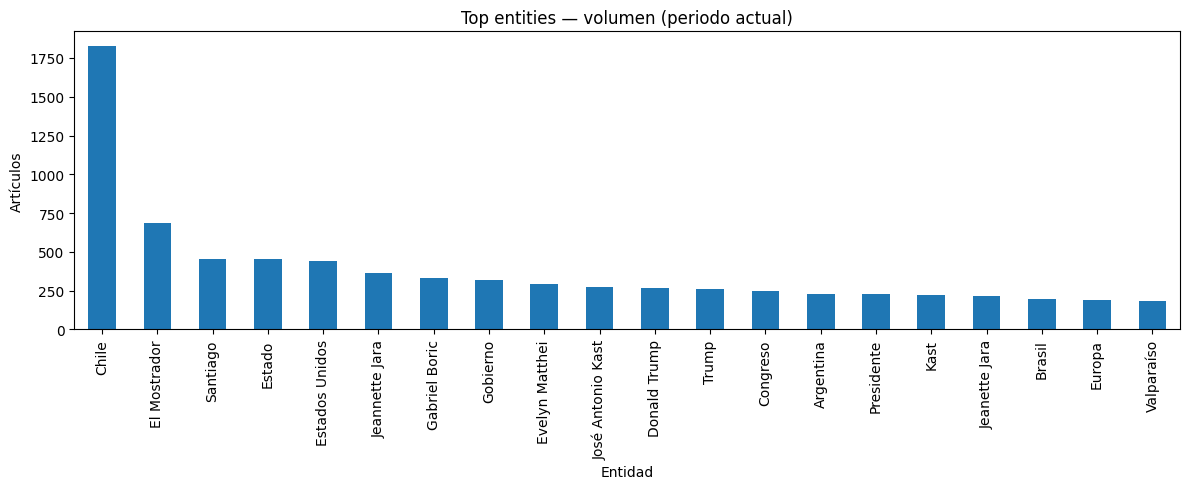

In [7]:
# Gráfico: Top entities por volumen (periodo actual)
if not top_df.empty:
    ax = top_df.set_index('entity_name')['n_now'].head(20).plot(kind='bar', figsize=(12,5))
    ax.set_title('Top entities — volumen (periodo actual)')
    ax.set_xlabel('Entidad')
    ax.set_ylabel('Artículos')
    plt.tight_layout()
    plt.show()

## 3) Sentiment por entidad (neg/neu/pos; avg polarity)

In [8]:
def sentiment_by_entity(df, top_entities_index, top_n=20):
    df_s = df[df['entity_name'].isin(top_entities_index)].copy()
    df_s = df_s[~df_s['polarity'].isna()]
    if df_s.empty:
        return pd.DataFrame(columns=['entity_name','n','pct_neg','pct_neu','pct_pos','avg_polarity'])
    agg = (df_s.groupby('entity_name')['polarity']
               .agg(['count', 'mean'])
               .rename(columns={'count':'n', 'mean':'avg_polarity'})
               .reset_index())
    # porcentajes por clase
    for lab, code in [('neg', -1), ('neu', 0), ('pos', 1)]:
        pct = (df_s.assign(match=(df_s['polarity']==code).astype(int))
                     .groupby('entity_name')['match']
                     .mean()
                     .mul(100).round(1)
                     .rename(f"pct_{lab}")
               )
        agg = agg.merge(pct, on='entity_name', how='left')
    return agg.sort_values('n', ascending=False).head(top_n)

top_names = top_df['entity_name'].head(TOP_N).tolist()
sent_df = sentiment_by_entity(df_cur, top_names, top_n=20)
sent_df.head(20)

,entity_name,n,avg_polarity,pct_neg,pct_neu,pct_pos
8,Chile,1829,-0.044013,32.2,40.0,27.8
15,El Mostrador,707,0.219236,18.2,41.6,40.2
17,Estado,487,-0.377823,48.3,41.3,10.5
43,Santiago,469,0.127932,22.6,42.0,35.4
18,Estados Unidos,443,-0.257336,41.1,43.6,15.3
25,Gobierno,436,-0.353211,44.0,47.2,8.7
29,Jeannette Jara,363,-0.322314,39.9,52.3,7.7
24,Gabriel Boric,333,-0.303303,40.8,48.6,10.5
20,Evelyn Matthei,295,-0.433898,46.1,51.2,2.7
30,José Antonio Kast,271,-0.453875,49.1,47.2,3.7


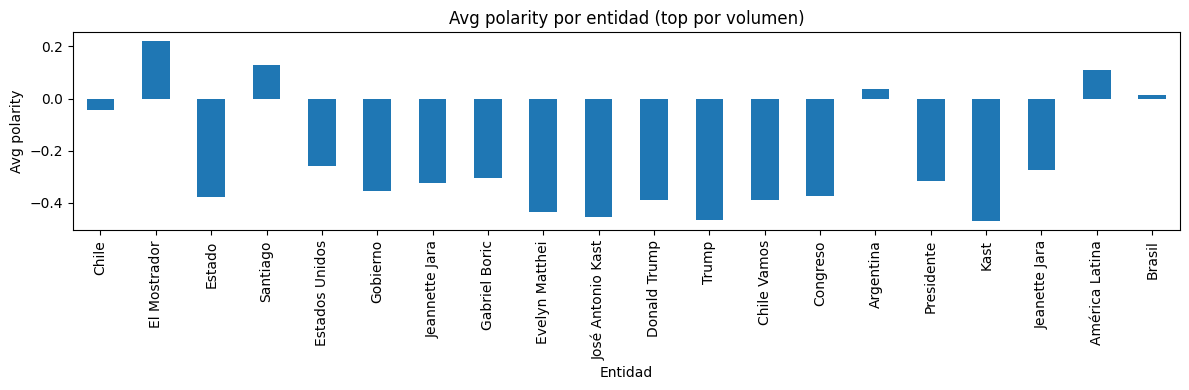

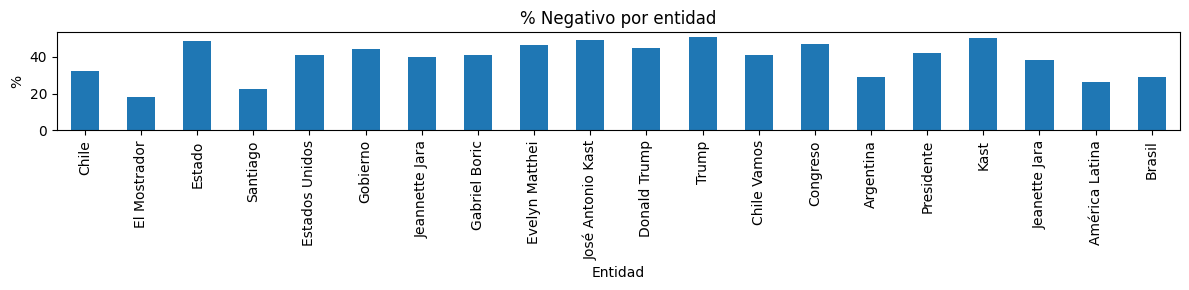

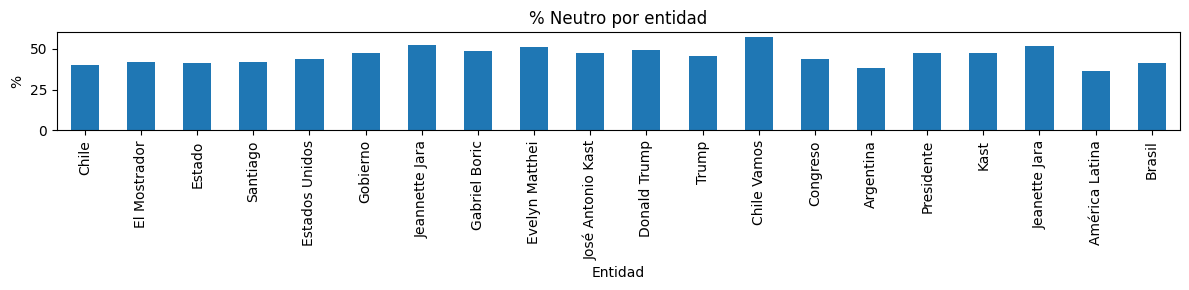

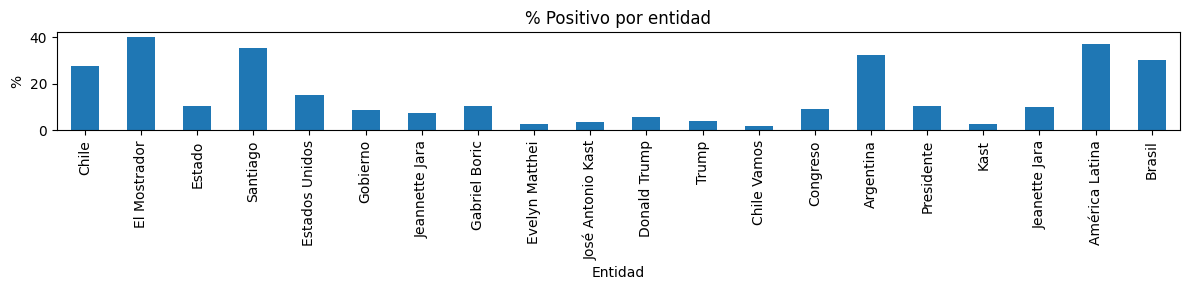

In [9]:
# Gráficos simples por clase (tres barras separadas)
if not sent_df.empty:
    ax = sent_df.set_index('entity_name')['avg_polarity'].plot(kind='bar', figsize=(12,4))
    ax.set_title('Avg polarity por entidad (top por volumen)')
    ax.set_xlabel('Entidad')
    ax.set_ylabel('Avg polarity')
    plt.tight_layout()
    plt.show()

    ax = sent_df.set_index('entity_name')['pct_neg'].plot(kind='bar', figsize=(12,3))
    ax.set_title('% Negativo por entidad')
    ax.set_xlabel('Entidad')
    ax.set_ylabel('%')
    plt.tight_layout()
    plt.show()

    ax = sent_df.set_index('entity_name')['pct_neu'].plot(kind='bar', figsize=(12,3))
    ax.set_title('% Neutro por entidad')
    ax.set_xlabel('Entidad')
    ax.set_ylabel('%')
    plt.tight_layout()
    plt.show()

    ax = sent_df.set_index('entity_name')['pct_pos'].plot(kind='bar', figsize=(12,3))
    ax.set_title('% Positivo por entidad')
    ax.set_xlabel('Entidad')
    ax.set_ylabel('%')
    plt.tight_layout()
    plt.show()

## 4) Subjectivity por entidad (media, p50/p75/p90, % alta ≥ 0.36)

In [10]:
def subjectivity_by_entity(df, top_entities_index, top_n=20):
    df_sub = df[df['entity_name'].isin(top_entities_index)].copy()
    df_sub = df_sub[~df_sub['subjectivity'].isna()]
    if df_sub.empty:
        cols = ['entity_name','n','avg_subjectivity','p50','p75','p90','pct_high_subjectivity']
        return pd.DataFrame(columns=cols)
    grp = df_sub.groupby('entity_name')['subjectivity']
    agg = pd.DataFrame({
        'n': grp.size(),
        'avg_subjectivity': grp.mean(),
        'p50': grp.quantile(0.5),
        'p75': grp.quantile(0.75),
        'p90': grp.quantile(0.9),
        'pct_high_subjectivity': grp.apply(lambda s: 100*s.ge(0.36).mean())
    }).reset_index()
    agg['avg_subjectivity'] = agg['avg_subjectivity'].round(3)
    agg['pct_high_subjectivity'] = agg['pct_high_subjectivity'].round(1)
    return agg.sort_values('n', ascending=False).head(top_n)

subj_df = subjectivity_by_entity(df_cur, top_names, top_n=20)
subj_df.head(20)

,entity_name,n,avg_subjectivity,p50,p75,p90,pct_high_subjectivity
8,Chile,1829,0.080,0.0778,0.09130,0.10404,0.1
15,El Mostrador,707,0.071,0.0700,0.08080,0.09144,0.0
17,Estado,487,0.078,0.0772,0.08950,0.10214,0.0
43,Santiago,469,0.073,0.0713,0.08410,0.09602,0.0
18,Estados Unidos,443,0.079,0.0776,0.08870,0.10184,0.0
25,Gobierno,436,0.073,0.0725,0.08205,0.09130,0.0
29,Jeannette Jara,363,0.069,0.0684,0.07760,0.08786,0.0
24,Gabriel Boric,333,0.071,0.0705,0.08190,0.09208,0.0
20,Evelyn Matthei,295,0.071,0.0713,0.08080,0.08940,0.0
30,José Antonio Kast,271,0.072,0.0712,0.08115,0.09010,0.0


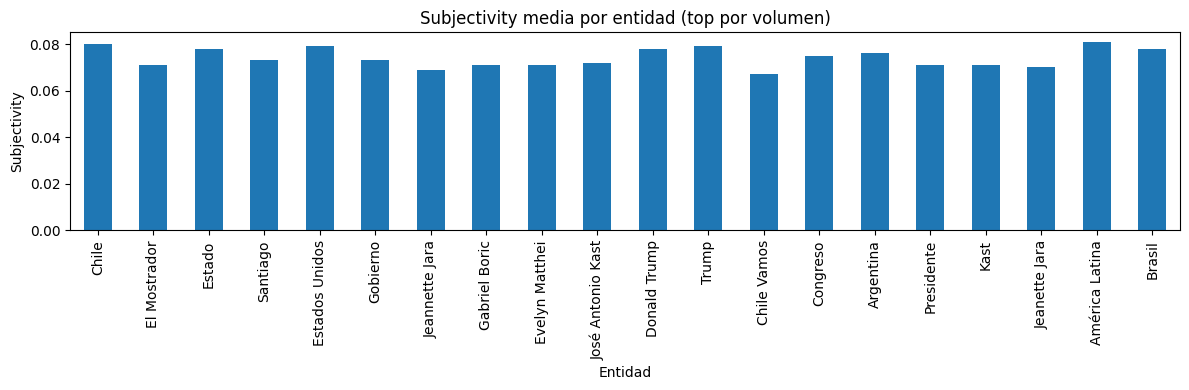

In [11]:
# Gráfico: avg_subjectivity
if not subj_df.empty:
    ax = subj_df.set_index('entity_name')['avg_subjectivity'].plot(kind='bar', figsize=(12,4))
    ax.set_title('Subjectivity media por entidad (top por volumen)')
    ax.set_xlabel('Entidad')
    ax.set_ylabel('Subjectivity')
    plt.tight_layout()
    plt.show()

## 6) Co-ocurrencias (pares de entidades más frecuentes)

In [12]:
def cooccurrences(df, top_entities_limit=200, top_pairs=100):
    if df.empty:
        return pd.DataFrame(columns=['ent1','ent2','n'])
    # Limitar al top por volumen para reducir combinatoria
    top_counts = df['entity_name'].value_counts().head(top_entities_limit).index
    sdf = df[df['entity_name'].isin(top_counts)]
    # Obtener entidades únicas por artículo
    groups = sdf.groupby('article_id')['entity_name'].apply(lambda s: sorted(set(s))).tolist()
    pair_counts = {}
    for ents in groups:
        if len(ents) < 2:
            continue
        for a,b in combinations(ents, 2):
            key = (a,b)
            pair_counts[key] = pair_counts.get(key, 0) + 1
    if not pair_counts:
        return pd.DataFrame(columns=['ent1','ent2','n'])
    coo = (pd.DataFrame([(k[0], k[1], v) for k,v in pair_counts.items()],
                        columns=['ent1','ent2','n'])
              .sort_values('n', ascending=False)
              .head(top_pairs)
          )
    return coo

coo_df = cooccurrences(df_cur, top_entities_limit=COOCC_TOP_ENTS, top_pairs=50)
coo_df.head(20)

,ent1,ent2,n
1175,Chile,El Mostrador,377
1124,Chile,Santiago,281
896,Chile,Estado,257
719,Gabriel Boric,Presidente,205
64,Evelyn Matthei,José Antonio Kast,201
1034,Chile,Estados Unidos,200
100,Jeanette Jara,Jeannette Jara,190
299,Chile,Gobierno,190
952,Donald Trump,Estados Unidos,190
959,Donald Trump,Trump,187


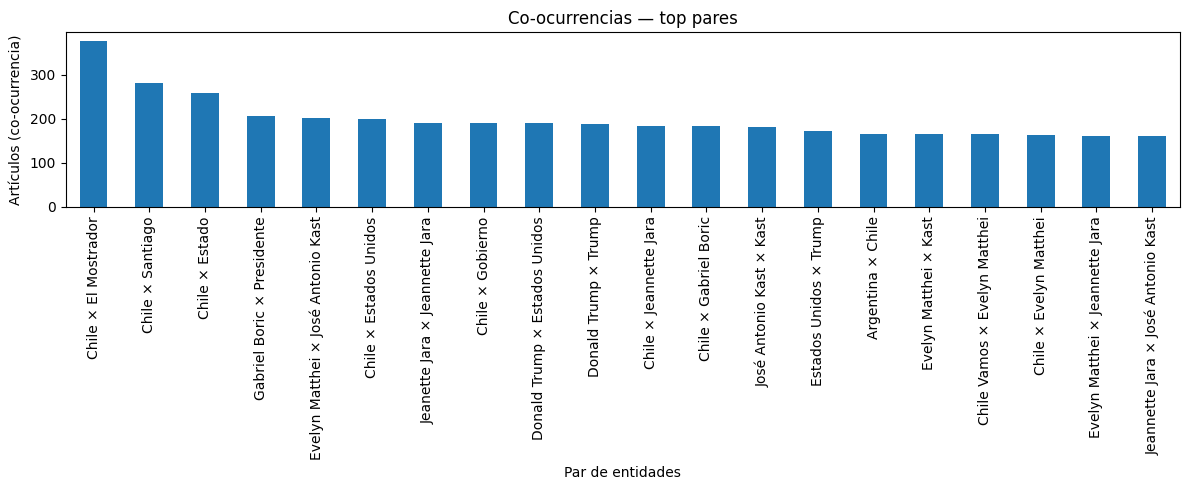

In [13]:
# Gráfico: top 20 pares por n
if not coo_df.empty:
    ax = coo_df.head(20).set_index(coo_df.head(20).apply(lambda r: f"{r['ent1']} × {r['ent2']}", axis=1))['n'] \
                        .plot(kind='bar', figsize=(12,5))
    ax.set_title('Co-ocurrencias — top pares')
    ax.set_xlabel('Par de entidades')
    ax.set_ylabel('Artículos (co-ocurrencia)')
    plt.tight_layout()
    plt.show()

## 8) Spikes/alertas por entidad (variación vs. promedio móvil 7 días)

In [14]:
def spikes_alerts(df, min_count=5, top_k=20):
    if df.empty:
        return pd.DataFrame(columns=['entity_name','date','count','ma7','ratio','delta'])
    # Daily counts
    ddf = df.copy()
    ddf['date'] = ddf['publication_date'].dt.floor('D')
    daily = (ddf.groupby(['entity_name','date'])
                 .size()
                 .rename('count')
                 .reset_index())
    # Moving average 7-day (por entidad)
    daily['ma7'] = (daily.sort_values(['entity_name','date'])
                         .groupby('entity_name')['count']
                         .transform(lambda s: s.rolling(window=7, min_periods=3).mean()))
    daily['ratio'] = daily['count'] / daily['ma7']
    daily['delta'] = daily['count'] - daily['ma7']
    # Filtrar spikes
    spikes = daily[(daily['count'] >= min_count) & (daily['ma7'] > 0)]
    spikes = spikes.sort_values(['ratio','count'], ascending=False).head(top_k)
    # redondeos
    spikes['ma7'] = spikes['ma7'].round(2)
    spikes['ratio'] = spikes['ratio'].round(2)
    spikes['delta'] = spikes['delta'].round(2)
    return spikes

spikes_df = spikes_alerts(df_cur, min_count=SPIKES_MIN_COUNT, top_k=SPIKES_TOP)
spikes_df.head(20)

,entity_name,date,count,ma7,ratio,delta
54634,Servel,2025-06-29,10,2.43,4.12,7.57
52279,Rusia,2025-07-30,11,2.71,4.05,8.29
26676,Gonzalo Winter,2025-06-29,20,5.00,4.00,15.00
29294,Independiente,2025-08-21,8,2.00,4.00,6.00
30930,Jaime Mulet,2025-06-29,18,4.57,3.94,13.43
29015,Iglesia,2025-09-05,9,2.43,3.71,6.57
32447,José Antonio Kast,2025-06-30,10,2.71,3.68,7.29
31466,Jeanette Jara,2025-06-29,12,3.29,3.65,8.71
52956,Salvador Allende,2025-09-01,6,1.71,3.50,4.29
2708,América Latina,2025-08-05,9,2.57,3.50,6.43


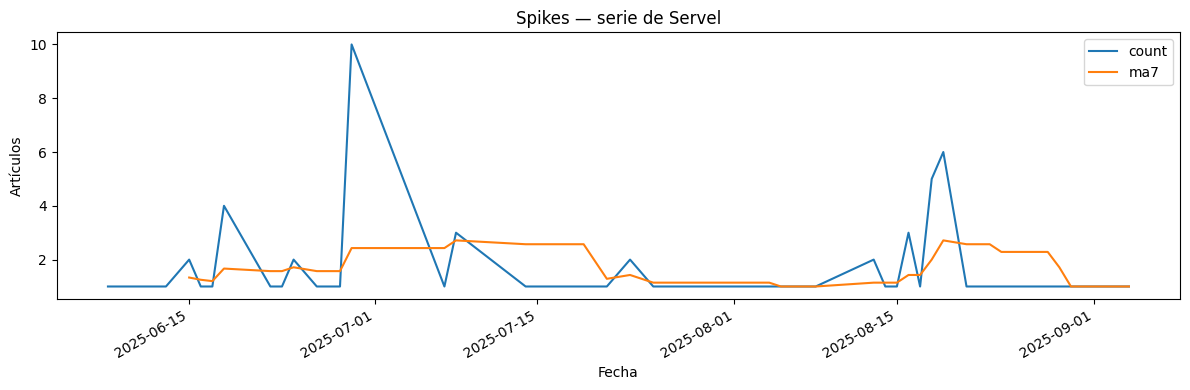

In [15]:
# Gráfico: serie temporal para la entidad con mayor spike
if not spikes_df.empty:
    top_ent = spikes_df.iloc[0]['entity_name']
    ddf = df_cur.copy()
    ddf['date'] = ddf['publication_date'].dt.floor('D')
    daily = (ddf[ddf['entity_name'] == top_ent]
             .groupby('date')
             .size()
             .rename('count')
             .reset_index()
             .sort_values('date'))
    daily['ma7'] = daily['count'].rolling(window=7, min_periods=3).mean()

    ax = daily.set_index('date')[['count','ma7']].plot(figsize=(12,4))
    ax.set_title(f"Spikes — serie de {top_ent}")
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Artículos')
    plt.tight_layout()
    plt.show()